In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import CCXGate, CXGate
from numpy import matmul, kron, sqrt
from numpy.linalg import norm
%matplotlib inline

# Superdense Coding
In short superdense coding using 1 Qubit to transfer 2 classical bits of communication at the cost of one e-bit.

Suppose we have a sender, Alice, and a receiver, Bob, that share one e-bit of entanglement. So Alice holds qbit A and Bob holds qbit B. Together the pair of bits is in the state
$$
\ket{\phi^+} = \frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}
$$
Alice wants to transmit 2 classical bits to Bob which we'll call $c$ and $d$ which she will do by sending him 1 Qubit. 
![title](Superdense/superdense-coding.png)
In words what happense
1. If $d = 1$ Alice performs a $Z$ gate on $A$
2. If $c = 1$ Alice performs an $X$ gate on $A$
3. Alice then sends her qbit to Bob
4. He then does a a control-not with A as the control and B as the target.
5. Then he does a hadamard on A. 
6. Finally, he measures B to obtain $c$ and A to obtain $d$.



### Analysis
The idea is fairly simple. Alice chooses which Bell state should would like to share with Bob, Bob then determines which Bell state Alice Chose. So what happens is Alice sends
$$
(I \otimes I)\ket{\phi^+} = \ket{\phi^+} \\
(I \otimes Z)\ket{\phi^+} = \ket{\phi^-} \\
(I \otimes X)\ket{\phi^+} = \ket{\psi^+} \\
(I \otimes XZ)\ket{\phi^+} = \ket{\psi^-} 
$$
Bob then does
$$
\ket{\phi^+} \to \ket{00} \\
\ket{\phi^-} \to \ket{01} \\
\ket{\psi^+} \to \ket{10} \\
\ket{\psi^-} \to -\ket{11} 
$$

In [61]:
# Sanity check on the math
ket_phip = Statevector([1/sqrt(2), 0, 0, 1/sqrt(2)])
ket_phim = Statevector([1/sqrt(2), 0, 0, -1/sqrt(2)])
ket_psip = Statevector([0, 1/sqrt(2), 1/sqrt(2), 0])
ket_psim = Statevector([0, 1/sqrt(2), -1/sqrt(2), 0])

## Show that alice convers ket_phip as expected
start = ket_phip

def alices(c, d, start):
    toReturn = start
    if d == "1":
        toReturn = toReturn.evolve(Operator.from_label("I") ^ Operator.from_label("Z"))
    if c == "1":
        toReturn = toReturn.evolve(Operator.from_label("I") ^ Operator.from_label("X"))    
    return toReturn
print("00 maps to phi p", ket_phip == alices("0", "0", start))
print("01 maps to phi m", ket_phim == alices("0", "1", start))
print("10 maps to psi plus", ket_psip == alices("1", "0", start))
print("11 maps to psi_m", ket_psim == alices("1", "1", start))

def bobs(start):
    return start.evolve(CXGate().to_matrix()).evolve(Operator.from_label("I") ^ Operator.from_label("H"))

bobs(start).draw('latex')
print("phi_+ -> |00>: ", bobs(ket_phip) == Statevector.from_label("00"))
print("phi_- -> |01>: ", bobs(ket_phim) == Statevector.from_label("01"))
print("psi_+ -> |10>: ", bobs(ket_psip) == Statevector.from_label("10"))
print("psi_- -> |11>: ", bobs(ket_psim) == Statevector.from_label("11"))

00 maps to phi p True
01 maps to phi m True
10 maps to psi plus True
11 maps to psi_m True
phi_+ -> |00>:  True
phi_- -> |01>:  True
psi_+ -> |10>:  True
psi_- -> |11>:  False


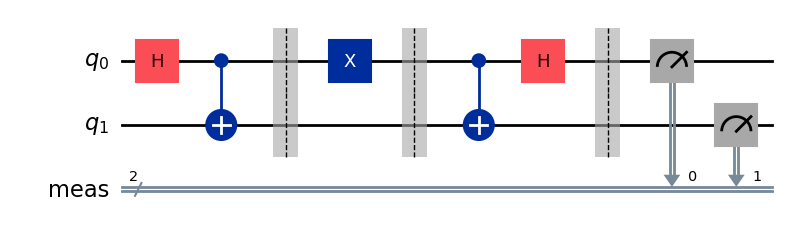

In [66]:
# assume 
c = "1"
d = "0"

# With circuit
protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw("mpl"))


Measured 10 with frequency 0.9999999999999996


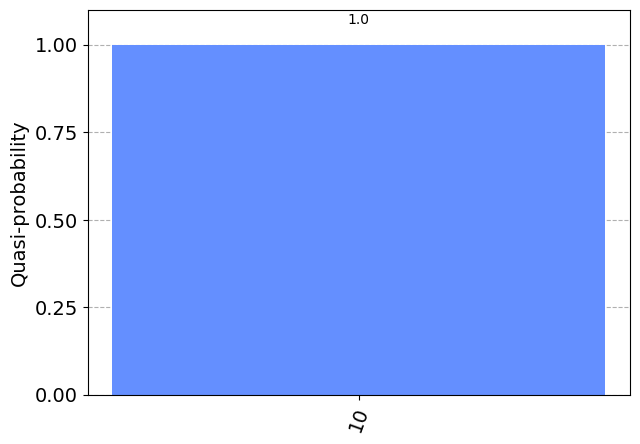

In [67]:
# Simulate
result = Sampler().run(protocol).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

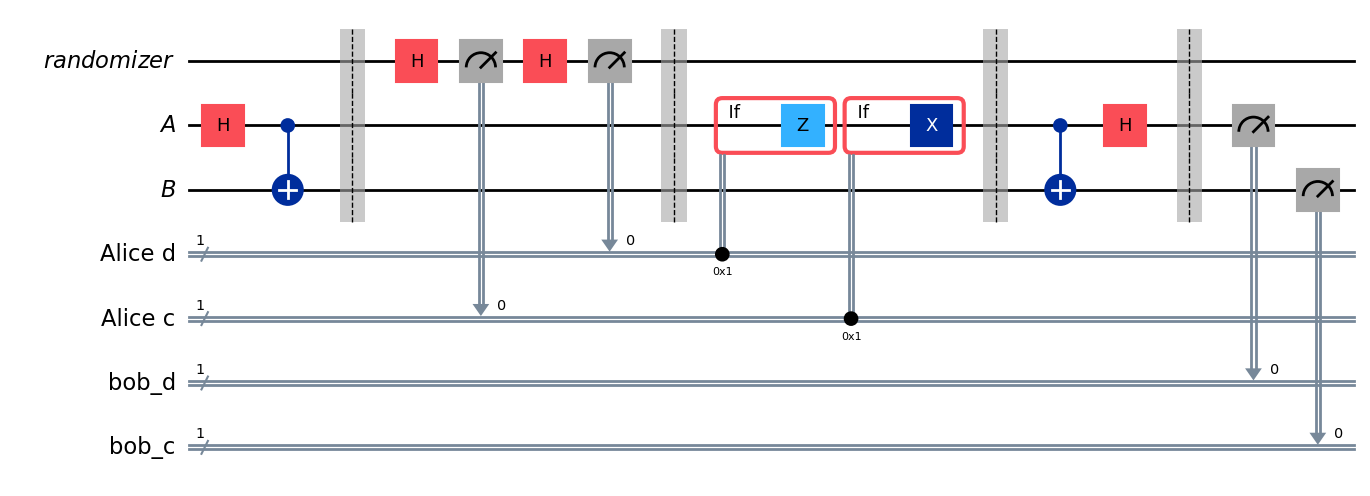

In [89]:
# For fun, lets use qubits to randomly generate c and d
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize ebit (I think this puts them in phi +)
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Get random values for c and d
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Add Alice's
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bobs
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

# Measure
bob_c = ClassicalRegister(1, "bob_c")
bob_d = ClassicalRegister(1, "bob_d")
test.add_register(bob_d)
test.add_register(bob_c)
test.measure(ebit0, bob_d)
test.measure(ebit1, bob_c)


display(test.draw("mpl"))


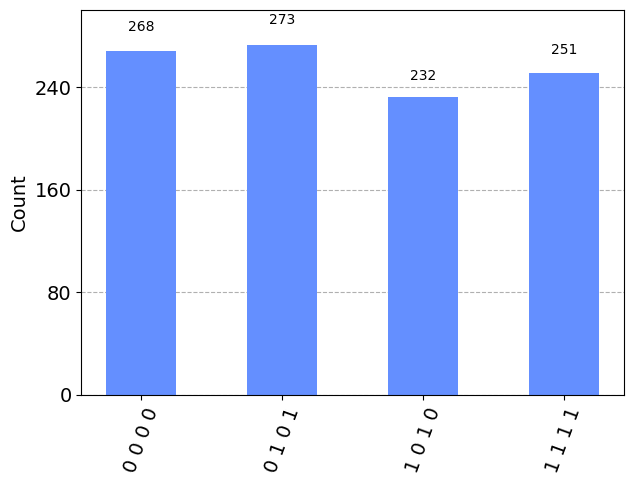

In [90]:
from qiskit_aer import AerSimulator

# Simulation should shows Alice and Bob's classical bits always agree
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))